# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

## 学習データ作成

In [16]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル作成

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

In [27]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


class AE(nn.Module):
    def __init__(self, z_dim):
        super(AE, self).__init__()
        self.enc1 = nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5)
        self.enc2 = nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3)
        self.flat = nn.Flatten(0, -1)
        self.enc3 = nn.Linear(16, z_dim)

        self.encmean = nn.Linear(16, z_dim)
        self.encvar = nn.Linear(16, z_dim)

        # self.dec1 = nn.Linear(z_dim, 200)
        self.dec1 = nn.Linear(z_dim,  16)
        self.unflat = nn.Unflatten(0, (1, 1 ,16))
        self.dec2 = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3, output_padding=1)
        self.dec3 = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5, padding = 1, output_padding=1)


    def _encoder(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = self.flat(x)
        mean = self.encmean(x)
        var = F.softplus(self.encvar(x))
        return mean, var

    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape).to(device)
        return mean + torch.sqrt(var) * epsilon

    def _decoder(self, z):
        x = F.relu(self.dec1(z))
        x = self.unflat(x)
        x = F.relu(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, var = self._encoder(x)
        # print(mean, var)
        # KL lossの計算
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(var) - mean**2 - var, dim=0))
        
        z = self._sample_z(mean, var)
        y = self._decoder(z)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction 

## モデル作成

## モデル学習

In [30]:
z_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(z_dim)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
for epoch in input_data:
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x in epoch:
        model.zero_grad()
        KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
        loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        KL_losses.append(KL_loss.detach().numpy())
        reconstruction_losses.append(reconstruction_loss.detach().numpy())

    losses_val = []
    model.eval()
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [7]:
model_name = "vaemodel"
ModelEdit = mainmodel.Modeledit("syuron")
ModelEdit.save_model(model, model_name) 

In [8]:
## 確認

tensor([[[0.0324, 0.0206, 0.0209, 0.0213, 0.0212, 0.0225, 0.0238, 0.0242,
          0.0246, 0.0246, 0.0231, 0.0238, 0.0241, 0.0246, 0.0245, 0.0251,
          0.0264, 0.0268, 0.0272, 0.0272, 0.0279, 0.0292, 0.0296, 0.0301,
          0.0300, 0.0312, 0.0328, 0.0332, 0.0337, 0.0336, 0.0317, 0.0325,
          0.0329, 0.0334, 0.0333, 0.0341, 0.0356, 0.0360, 0.0365, 0.0365,
          0.0375, 0.0391, 0.0396, 0.0401, 0.0401, 0.0359, 0.0362, 0.0366,
          0.0371, 0.0371, 0.0379, 0.0394, 0.0399, 0.0404, 0.0403, 0.0413,
          0.0429, 0.0434, 0.0439, 0.0438, 0.0387, 0.0389, 0.0394, 0.0399,
          0.0398, 0.0406, 0.0422, 0.0427, 0.0432, 0.0432, 0.0440, 0.0457,
          0.0461, 0.0467, 0.0466, 0.0465, 0.0478, 0.0483, 0.0489, 0.0488,
          0.0495, 0.0512, 0.0517, 0.0523, 0.0522, 0.0533, 0.0551, 0.0556,
          0.0562, 0.0562, 0.0573, 0.0591, 0.0597, 0.0603, 0.0602, 0.0608,
          0.0624, 0.0630, 0.0636, 0.0635, 0.0647, 0.0665, 0.0670, 0.0677,
          0.0676, 0.0686, 0.0704, 0.07

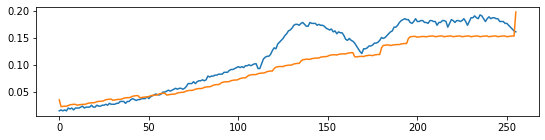

normal:6.147871335968375


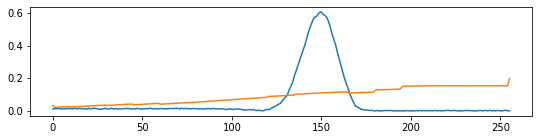

anomarly:27.13038005772978
anomaly
<class 'torch.Tensor'>


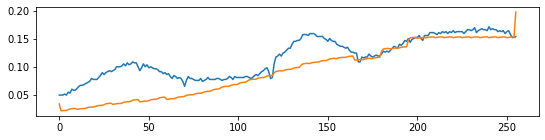

normal:6.496206942945719


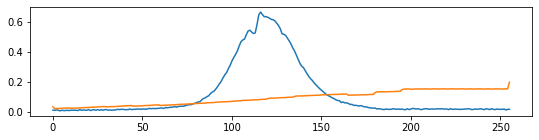

anomarly:32.64293973892927
anomaly
<class 'torch.Tensor'>


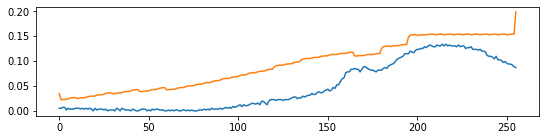

normal:11.246612360700965
anomaly


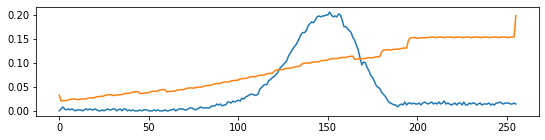

anomarly:17.55188599601388
anomaly
<class 'torch.Tensor'>


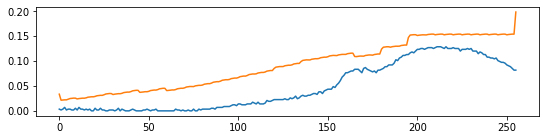

normal:11.110746957361698
anomaly


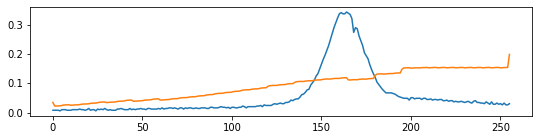

anomarly:17.814969480969012
anomaly
<class 'torch.Tensor'>


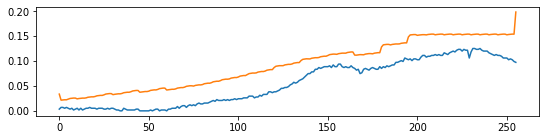

normal:9.368082931265235


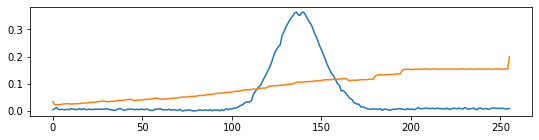

anomarly:23.154593599960208
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [32]:
# num = 5
data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
data0 = data0[np.newaxis, np.newaxis, :]
recon, _ = model(data0)
recon = recon.detach()
print(recon)

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        input_data = data0[np.newaxis, np.newaxis, :]
        recon,_ = model(input_data)
        recon = recon.detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        input_data = test0[np.newaxis, np.newaxis, :]
        recon,_ = model(input_data)
        recon = recon.detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")